<a href="https://colab.research.google.com/github/luciadeangulo/UFV-Visualizacion/blob/main/ejercicios_clase/clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJERCICIO HISTÓRICO DE VENTAS EN EUROPA

**VISUALIZACIÓN DE DATOS**

Lucía de Angulo Pelayo


In [149]:
!pip install plotly_express
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import seaborn as sns
import numpy as np

Se carga el dataset:

In [150]:
import pandas as pd
df = pd.read_csv('datos_ejercicio_ventas.csv')
print(df.head())

         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L3)  2023      9  AI_forecast  AI_P03F   

   FORECAST_YEAR         AMOUNT  
0         2023.0  754356.237194  
1         2023.0  560030.558029  
2         2023.0   88501.980847  
3         2023.0  363224.511516  
4         2023.0  396176.120491  


**amount** : volumen ventas en litros

**subbrand** : producto que se ha vendido (lipton ej)

**scenario** : Ai_forecast(se ha predicho) o actual(venta real)

**month** : en caso de forecast, esto indica para cuándo se hace la predicción

**forecast** : mes cuando se hizo la predicción.  numero-1 = mes (2-12). pero diciembre es solo PF.

**forecast_year** : año cuando se hizo la predicción

Las variables YEAR y MONTH se pasan a Python datetime.

In [151]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))

df['DATE'] = df['DATE'].dt.to_period('M') # QUITAR DÍA (SE PONE POR DEFECTO)

# PASAR A FORMATO DATETIME
df['DATE'] = df['DATE'].dt.to_timestamp()
print(df[['YEAR', 'MONTH', 'DATE']].head())

   YEAR  MONTH       DATE
0  2023     12 2023-12-01
1  2023     12 2023-12-01
2  2023     12 2023-12-01
3  2024     12 2024-12-01
4  2023      9 2023-09-01


In [152]:
print(df.describe())
print(df.info())

               YEAR         MONTH  FORECAST_YEAR        AMOUNT  \
count  18666.000000  18666.000000        17766.0  1.866600e+04   
mean    2023.716383      6.475463         2023.0  9.721822e+05   
min     2023.000000      1.000000         2023.0 -2.171201e+05   
25%     2023.000000      3.000000         2023.0  8.754541e+04   
50%     2024.000000      6.000000         2023.0  3.081759e+05   
75%     2024.000000      9.000000         2023.0  1.078576e+06   
max     2025.000000     12.000000         2023.0  1.481563e+07   
std        0.590782      3.463632            0.0  1.915283e+06   

                                DATE  
count                          18666  
mean   2024-03-03 18:27:57.917068544  
min              2023-01-01 00:00:00  
25%              2023-10-01 00:00:00  
50%              2024-03-01 00:00:00  
75%              2024-08-01 00:00:00  
max              2025-05-01 00:00:00  
std                              NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866

No hay valores null.  Hay 18666 registros por columna, excepto en las variables relacionadas con las previsiones, lo cual tiene sentido porque hay registros que son reales y no predichos.

Parece que hay al menos un valor negativo en la variable Amount, lo cual no tiene sentido.

In [153]:
amount_negativos = df[df['AMOUNT']<0]
amount_negativos.shape

(10, 9)

De casi 19000 registros, tan solo hay 10 registros con las ventas negativas.  Se eliminarán, ya que es una cantidad despreciable.

In [154]:
df = df[df['AMOUNT']>=0]

Se revisará si hay datos duplicados.

In [155]:
duplicados = df[df.duplicated()]
duplicados

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE
349,Great Britain,Lipton (L3),2024,9,AI_forecast,AI_P11F,2023.0,7.367201e+05,2024-09-01
455,Great Britain,Lipton (L3),2024,6,AI_forecast,AI_P03F,2023.0,8.156165e+05,2024-06-01
540,Great Britain,7up Free (L3),2024,2,AI_forecast,AI_PF,2023.0,9.402300e+05,2024-02-01
652,Great Britain,Lipton (L3),2024,1,AI_forecast,AI_P05F,2023.0,5.730475e+05,2024-01-01
789,Great Britain,Lipton (L3),2024,11,AI_forecast,AI_P11F,2023.0,7.039466e+05,2024-11-01
...,...,...,...,...,...,...,...,...,...
18590,Hungary,7up (L3),2025,1,AI_forecast,AI_P12F,2023.0,0.000000e+00,2025-01-01
18606,Great Britain,7up Free (L3),2024,8,AI_forecast,AI_P03F,2023.0,1.117629e+06,2024-08-01
18631,Great Britain,7up (L3),2024,10,AI_forecast,AI_P11F,2023.0,7.512755e+04,2024-10-01
18649,Great Britain,Lipton (L3),2024,5,AI_forecast,AI_P11F,2023.0,9.124481e+05,2024-05-01


Hay 663 registros duplicados.  No aportan información, más bien pueden perturbar los datos.  Por ejemplo, si hay muchos duplicados de España, el número de ventas que se cuenta no es el real.  Se eliminan.

In [156]:
df = df.drop_duplicates()

**PREGUNTAS PREVIAS PARA ENTENDER LOS DATOS:**

1. Número actuals y forecasts

2. Horizonte de predicción (si hago previsión para enero y febrero, ej, el horizonte de predicción es 2, con frecuencia mensual): tiempo hacia el futuro para el cual se hacen previsiones.

3. Nº países y de productos

4. Histórico de actuals y forecasts

5. Forecasts distintos.

1. Números Actuals y Forecasts

In [157]:
num_act_forecast = df['SCENARIO'].value_counts()
num_act_forecast

,count
SCENARIO,
AI_forecast,17103
actual,890


Las predicciones son la mayor parte del dataset.

2. Horizonte de predicción

In [158]:
# solo tengo en cuenta los registros que son predicciones
predicciones = df[df['SCENARIO'] == 'AI_forecast']
#último año + mes de las predicciones totales
#uso variable year porque quiero el año para el cual predigo, no en el que predigo
max_year = predicciones['YEAR'].max()
max_month = predicciones[predicciones['YEAR'] == max_year]['MONTH'].max()
max_year, max_month

(2025, 5)

Ya tengo el mes (mayo) y el año (2025) para cuando se ha hecho la última predicción.  Ahora necesito el último mes+año de 'actual' para ver cuál es el último dato 'real' de ventas.

In [159]:
actuals = df[df['SCENARIO'] == 'actual']
fecha_max = actuals['DATE'].max()
fecha_max

Timestamp('2024-08-01 00:00:00')

El horizonte de predicción es de 9 meses (desde agosto 2024 a mayo 2025 van 9 meses).

3.  Número de países y productos

In [160]:
paises = df['COUNTRY'].value_counts()
productos = df['SUBBRAND'].value_counts()
paises, productos

(COUNTRY
 Great Britain    3372
 Netherlands      2476
 Hungary          2358
 Denmark          2294
 Spain            2152
 Norway           2051
 Czech            1403
 Portugal         1179
 Italy             708
 Name: count, dtype: int64,
 SUBBRAND
 Pepsi Max (L3)        5538
 Pepsi Regular (L3)    3576
 Lipton (L3)           2484
 7up (L3)              2470
 7up Free (L3)         2283
 Mountain Dew (L3)     1642
 Name: count, dtype: int64)

De Reino Unido hay muchos más registros que de otros países como Italia, que es el que menos observaciones tiene.  Esto puede alterar los datos ya que la muestra de unos países es mucho mayor que la de otros.

Lo mismo ocurre con los productos: los registros son muy desiguales.  De Mountain Dew hay casi 5 veces menos observaciones que para la Pepsi Max.

Hay 9 países y 6 marcas de bebidas.

3.  Histórico Actuals y Forecasts de todo el conjunto de datos

In [161]:

historico = df.groupby(['DATE', 'SCENARIO'])['AMOUNT'].sum().reset_index()


# GRÁFICO LINEAS
fig = px.line(historico, x='DATE', y='AMOUNT', color='SCENARIO', markers=True,
              title='Histórico Ventas Actuales vs Predichas')

fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Número Ventas',
    legend_title_text='Scenario',
    xaxis=dict(tickformat='%Y-%m'),
    template='plotly_white'
)
fig.update_xaxes(tickangle=65)

fig.show()


5.  Los distintos forecasts

In [162]:
dist_forecasts = df['FORECAST'].unique()

print(dist_forecasts)


['AI_P02F' 'AI_P10F' 'AI_P09F' 'AI_P03F' 'AI_PF' 'AI_P11F' 'AI_P06F'
 'AI_P05F' 'AI_P07F' 'AI_P12F' 'AI_P08F' 'AI_P04F' nan]


Se hacen predicciones para cada mes del año.

In [163]:
forecast_iguales = df.groupby(['COUNTRY', 'SUBBRAND', 'FORECAST']).size().reset_index(name='COUNT')
forecast_iguales

,COUNTRY,SUBBRAND,FORECAST,COUNT
0,Czech,7up (L3),AI_P02F,18
1,Czech,7up (L3),AI_P03F,18
2,Czech,7up (L3),AI_P04F,18
3,Czech,7up (L3),AI_P05F,18
4,Czech,7up (L3),AI_P06F,18
...,...,...,...,...
559,Spain,Pepsi Regular (L3),AI_P09F,54
560,Spain,Pepsi Regular (L3),AI_P10F,54
561,Spain,Pepsi Regular (L3),AI_P11F,54
562,Spain,Pepsi Regular (L3),AI_P12F,54


In [164]:
unique_counts = forecast_counts['COUNT'].unique()
unique_counts

array([ 18,  36,  54,  90, 180,  42,  59,  58,  60,  27,  25,  72,  29])

Para cada país y bebida el número de predicciones es demasiado desigual.  También puede afectar negativamente a nuestro análisis.

**PREGUNTAS A RESPONDER**
1. Cómo se distribuyen las ventas realizadas en cada país, mes y año y marca.

2. Cuál es la tendencia y estacionalidad de todas las ventas del país con menos ventas y la marca con más ventas.

3.  Cuáles son las predicciones hechas en España y qué tan buenas son.

******************************************************************

Para los ejercicios 1 y 2 solo se usan los registros de actuals, que son los datos reales.



In [165]:
df_actuals = df[df['SCENARIO']=='actual']

1. Cómo se distribuyen las ventas realizadas en cada país: mes, año y marca.

In [166]:
fig = px.bar(df_actuals, x="COUNTRY", y="AMOUNT", color="SUBBRAND",
             title="Ventas por País y Submarca", labels={"AMOUNT": "Ventas totales", "COUNTRY": "País", "SUBBRAND": "Producto"})

fig.update_layout(
    xaxis_title="País",
    yaxis_title="Ventas totales",
    legend_title_text="Producto",
)

fig.update_xaxes(tickangle=65)

fig.show()

Se ve claramente que en Reino Unido se consumen muchos más refrescos que en el resto de Europa.  España y Portugal consumen de manera equilibrada todas las bebidas.  España destaca en lo poco que consume.

Se hará una gráfica por país para que se vea mejor.

In [167]:
paises = df_actuals['COUNTRY'].unique()
num_paises = len(paises)

fig = make_subplots(rows=3, cols=3, subplot_titles=paises)

# UN GRÁFICO POR PAÍS
for i,pais in enumerate(paises):
    # Filtrar datos por país
    datos_paises = df_actuals[df_actuals['COUNTRY'] == pais]

    # Obtener la fila y columna del subplot
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Crear el gráfico de barras para el país actual
    fig.add_trace(
        go.Bar(x=datos_paises['SUBBRAND'], y=datos_paises['AMOUNT'], name=pais),
        row=row, col=col)

    # Personalizar ejes y títulos
    fig.update_xaxes(title_text="Producto", row=row, col=col, tickangle=45)
    fig.update_yaxes(title_text="Ventas totales", row=row, col=col)

# Actualizar el diseño general
fig.update_layout(height=rows * 400, width=1000, title_text="Ventas Totales por Producto en cada País", showlegend=False)
fig.show()


DISTRIBUCIÓN BEBIDAS POR PAÍS:

En Portugal se consume más Lipton, aunque no hay una drástica diferencia con las demás bebidas.  En Reino Unido hay una gran preferencia por Pepsi Max, lo que sugiere que es muy popular en el mercado.

En España las ventas también están equilibradas (como en Portugal), pero la Pepsi, ya sea Max o Regular es la más consumida, aunque el 7Up no se queda demasiado atrás en las ventas.  En Italia se vende mucho más la Pepsi Regular que el 7Up o la Pepsi Max.  Parece que en los países de la península ibérica y/o mediterráneos no está tan popularizado el consumo de bebidas azucaradas, ya que en comparación a los otros países toman bastante menos.

En Hungría, Noruega, Dinamarca y República Checa la Pepsi gana con diferencia a las demás bebidas.  Esto es un indicador de que en países más frios y lluviosos (también Reino Unido, como ya se ha visto) la Pepsi se consume bastante.  En cambio, en Países Bajos, la bebida más consumida es el Lipton, aunque no es drásticamente más popular que la Pepsi.

En ningún país parece ser que el 7Up o el Mountain Dew sean favoritos.  Mountain Dew aparece con ventas considerablemente bajas en todos los países.

Algo curioso es que en los países más calurosos, com Italia o España, se prefiere la Pepsi Regular (más calorías).  En países muy al norte, como Dinamarca o Noruega, se prefiere la Pepsi Max.

Ahora se analizarán las ventas de cada país por meses.

<Figure size 1500x1000 with 0 Axes>

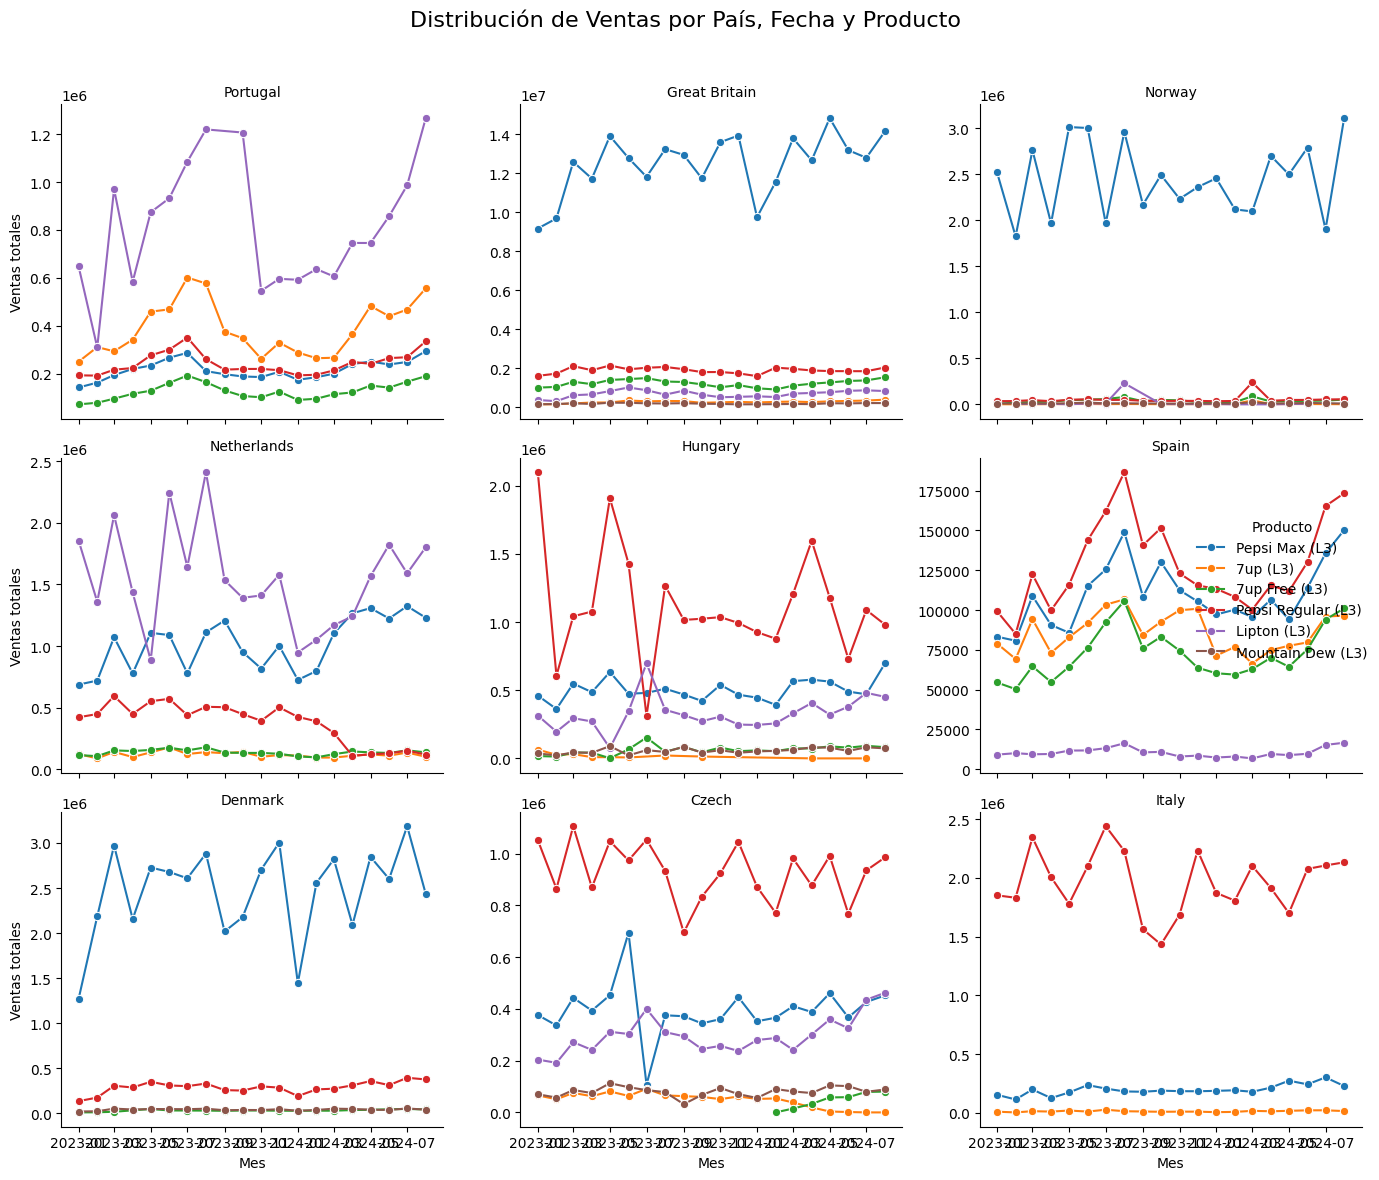

In [168]:
plt.figure(figsize=(15, 10))

# DISTRIBUCIÓN VENTAS POR FECHA, PAÍS Y PRODUCTO
# GRÁFICO LINEAS
graf= sns.FacetGrid(df_actuals, col="COUNTRY", hue="SUBBRAND", col_wrap=3, height=4, sharey=False)
graf.map(sns.lineplot, "DATE", "AMOUNT", marker="o")

graf.add_legend(title="Producto")
graf.set_axis_labels("Mes", "Ventas totales")
graf.set_titles("{col_name}")


# Título y ajuste de la visualización
plt.suptitle("Distribución de Ventas por País, Fecha y Producto", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


En España, Portugal e Italia se ve una clara tendencia ascendente de las compras en los meses más calurosos como Julio y Agosto, lo cual es coherente, pues en estos países el clima es muy caluroso en dichos meses, por lo que la gente estará más dispuesta a comprar bebidas frías.

En Reino Unido hay cierta estacionalidad, no destaca ningún mes o período específico.  Las personas suelen comprar bebidas durante todo el año en la misma medida.

En Hungría, Noruega, Dinamarca y República Checa se sigue una tendencia similar: desde enero hasta mayo/junio las ventas crecen considerablemente, hasta octubre vuelven a disminuir y desde ahí hasta diciembre vuelve la tendencia ascendente.  Son países con climas similares, por lo que es normal que la gente tienda a comprar bebidas al mismo tiempo y en los mismos meses.  En Países Bajos hay una tendencia similar a la de estos países, pero no son cambios tan bruscos (no hay tantos picos), si no que la función de las compras es más suave.

2. Cuál es la tendencia y estacionalidad de todas las ventas del país con menos ventas y la marca con más ventas.

Primero se identificarán el país con menos ventas y la marca con más.

In [169]:
ventas_pais = df_actuals.groupby('COUNTRY')['AMOUNT'].sum().sort_values()
pais_min = ventas_pais.index[0]

# Encontrar la marca con m\u00e1s ventas totales
ventas_marca = df_actuals.groupby('SUBBRAND')['AMOUNT'].sum().sort_values(ascending=False)
marca_max = ventas_marca.index[0]

print("PAÍS CON MENOS VENTAS:", pais_min)
print("MARCA CON MÁS VENTAS:", marca_max)

PAÍS CON MENOS VENTAS: Spain
MARCA CON MÁS VENTAS: Pepsi Max (L3)


Pepsi Max es el producto más vendido.  Pepsi es la marca más vendida contando los productos de Pepsi Max + Pepsi Regular.

Ahora se analizará la tendencia de la venta de Pepsi Max (elijo el producto más vendido en vez de la marca) en España y la estacionalidad cada mes.

TENDENCIA:

In [170]:
fig = px.line(spain_monthly, x='DATE', y='AMOUNT', title='Tendencia Pepsi Max en España', markers=True)

fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Ventas totales',
    xaxis=dict(tickangle=45),
    template='plotly_white'
)

fig.show()

En las fechas de julio y agosto sube considerablemente la venta de Pepsi Max, lo cual tiene sentido ya que son los meses con más calor en España.  Los picos más altos de ventas son ambos el 1 de agosto de 2023 y 2024.  Desde octubre de 2023 bajan las ventas considerablemente hasta que en Mayo se vuelve a remontar (empieza el clima más caluroso).  No hay una diferencia considerable de ventas entre los dos años.

In [171]:
fig = px.bar(
    spain_seasonal,
    x=spain_seasonal.index,
    y=spain_seasonal.values,
    title='Estacionalidad mensual en España de la Pepsi Max',
    labels={'x': 'Mes', 'y': 'Ventas medias'}
)

fig.update_layout(
    xaxis_title='Mes',
    yaxis_title='Ventas medias',
    template='plotly_white'
)

fig.show()

3. Predicciones hechas en España y qué tan buenas son.

Se calculará primero el error de las predicciones.

In [172]:
df_spain = df[df['COUNTRY'] == 'Spain']

df_spain_predic = df_spain[df_spain['SCENARIO'] == 'AI_forecast']

print(df_spain_predic.head())

df_spain_real = df_spain[df_spain['SCENARIO'] != 'AI_forecast']


real_vs_pred = df_spain_real.groupby('DATE')['AMOUNT'].sum().reset_index()
pred_vs_real = df_spain_predic.groupby('DATE')['AMOUNT'].sum().reset_index()
comparison = pd.merge(real_vs_pred, pred_vs_real, on='DATE', suffixes=('_real', '_pred'))
comparison['error'] = (comparison['AMOUNT_pred'] - comparison['AMOUNT_real']).abs()
comparison['error_percentage'] = (comparison['error'] / comparison['AMOUNT_real']) * 100
print(comparison.head())

   COUNTRY            SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
2    Spain      Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
20   Spain  Pepsi Regular (L3)  2023     12  AI_forecast  AI_P05F   
25   Spain         Lipton (L3)  2025      3  AI_forecast  AI_P11F   
62   Spain       7up Free (L3)  2024      1  AI_forecast  AI_P04F   
68   Spain            7up (L3)  2024      4  AI_forecast  AI_P02F   

    FORECAST_YEAR         AMOUNT       DATE  
2          2023.0   88501.980847 2023-12-01  
20         2023.0  134268.151080 2023-12-01  
25         2023.0    9702.217953 2025-03-01  
62         2023.0   70144.329753 2024-01-01  
68         2023.0   38882.921227 2024-04-01  
        DATE    AMOUNT_real   AMOUNT_pred         error  error_percentage
0 2023-01-01  325272.938930  3.227921e+05  2.480865e+03          0.762703
1 2023-02-01  295588.379605  6.341964e+05  3.386081e+05        114.553914
2 2023-03-01  399710.273110  9.632081e+05  5.634978e+05        140.976563
3 2023-04-01 

In [173]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=comparison['DATE'],
    y=comparison['AMOUNT_real'],
    mode='lines+markers',
    name='Real'
))

fig.add_trace(go.Scatter(
    x=comparison['DATE'],
    y=comparison['AMOUNT_pred'],
    mode='lines+markers',
    name='Predicción'
))

# Personalizar el diseño
fig.update_layout(
    title='ACTUALS VS PREDICCIONES SPAIN',
    xaxis_title='Fecha',
    yaxis_title='Ventas',
    xaxis=dict(tickangle=45),
    legend_title_text='Tipo',
    template='plotly_white'
)

# Mostrar el gráfico
fig.show()


Hay una gran diferencia entre las predicciones y los valores reales.  Los valores actuals son muy estacionales, a diferencia de las predicciones, que tienen una tendencia alcista.

Las predicciones no son precisas en absoluto.

In [175]:
fig = px.line(
    comparison,
    x='DATE',
    y='error_percentage',
    title='Error Porcentual de las Predicciones',
    markers=True
)

fig.update_traces(line=dict(color='red'))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Error (%)',
    xaxis=dict(tickangle=45),
    template='plotly_white'
)

fig.show()

Ahora se calcula la media de error absoluto.

In [176]:
abs_error = comparison['error_percentage'].mean()
print("MAE:", abs_error, "%")

MAE: 1736.2834961067456 %


Hay una desviación demasiado grande.  Las predicciones han fallado mucho.